# LSTM

## Importar datos

In [50]:
import sys
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import datetime
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras.layers import Dense, Input, Dropout
from keras.optimizers import SGD
from keras.models import Model
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
import os
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
import statsmodels.tsa.api as smtsa
import statsmodels.tsa.arima.model as arima_model
import warnings
warnings.filterwarnings("ignore")
from keras.layers import Dense, Input, Dropout
from keras.layers import LSTM
from keras.optimizers import SGD
from keras.models import Model
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
import os
from keras.optimizers import Adam
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox

In [3]:
# Lectura de los datos
import os
os.chdir("C:\\Users\\ANGIE VANESA\\TRABAJOS\\SERIES DE TIEMPO")
pm10 = pd.read_csv("datos_imputados 1.csv", sep=",")
len(pm10)

51096

## Preprocesar datos

In [4]:
pm10['datetime'] = pd.to_datetime(pm10['fecha'])
pm10['datetime'] = pd.to_datetime(pm10['datetime'])
pm10['datetime'] = pm10['datetime'].dt.strftime('%Y-%m-%d %H:%M:%S')
pm10["fecha"]= pd.to_datetime(pm10["fecha"])
pm10["dia"]= pm10["fecha"].dt.day
pm10["hora"]= pm10["fecha"].dt.hour

In [5]:
pm10.head()

,Unnamed: 0,fecha,estacion,black_carbon,direccion_viento,h2s,humedad,lluvia,no2,o3,...,Year,Mes,pm10_LOCF,pm10_linear_interpolation,pm10_moving_average,pm10_kalman,pm10_arima,datetime,dia,hora
0,4,2017-01-01 00:59:59+00:00,ermita,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2017,1,61.9,61.9,61.9,61.9,61.9,2017-01-01 00:59:59,1,0
1,13,2017-01-01 01:59:59+00:00,ermita,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2017,1,101.0,101.0,101.0,101.0,101.0,2017-01-01 01:59:59,1,1
2,22,2017-01-01 02:59:59+00:00,ermita,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2017,1,75.6,75.6,75.6,75.6,75.6,2017-01-01 02:59:59,1,2
3,31,2017-01-01 03:59:59+00:00,ermita,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2017,1,56.3,56.3,56.3,56.3,56.3,2017-01-01 03:59:59,1,3
4,40,2017-01-01 04:59:59+00:00,ermita,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2017,1,107.1,107.1,107.1,107.1,107.1,2017-01-01 04:59:59,1,4


### Conjunto de entrenamiento, validación y prueba

Antes de entrenar el modelo, el conjunto de datos se divide en tres partes: el conjunto de entrenamiento y el conjunto de validación y prueba. La red neuronal se entrena en el conjunto de entrenamiento.

In [6]:
pm10['datetime'] = pd.to_datetime(pm10['datetime'])
split_date = datetime.datetime(year=2020, month=10, day=30, hour=0, minute=59, second=59)
df_train = pm10.loc[pm10['datetime']<split_date]
df_val = pm10.loc[pm10['datetime']>=split_date]
print('Shape of train:', df_train.shape)
split_date = datetime.datetime(year=2022, month=5, day=30, hour=0, minute=59, second=59)
df_val1 = df_val.loc[df_val['datetime']<split_date]
df_test = df_val.loc[df_val['datetime']>=split_date]
print('Shape of val:', df_val1.shape)
print('Shape of test:', df_test.shape)

Shape of train: (33552, 30)
Shape of val: (13848, 30)
Shape of test: (3696, 30)


In [7]:
df_val.reset_index(drop=True, inplace=True)
df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

El conjunto de validación se utiliza para evaluar el modelo y determinar el número de épocas en su entrenamiento

Ahora necesitamos generar los regresores (X) y la variable objetivo (y) para el entrenamiento y la validación. 

In [8]:
def makeXy(ts, nb_timesteps):
    """
    Input: 
           ts: original time series
           nb_timesteps: number of time steps in the regressors
    Output: 
           X: 2-D array of regressors
           y: 1-D array of target 
    """
    X = []
    y = []
    for i in range(nb_timesteps, ts.shape[0]):
        if i-nb_timesteps <= 4:
            print(i-nb_timesteps, i-1, i)
        X.append(list(ts.loc[i-nb_timesteps:i-1])) #Regressors
        y.append(ts.loc[i]) #Target
    X, y = np.array(X), np.array(y)
    return X, y

Escalamos la variable con MinMax para limitar la variable dentro del intervalo [0,1] 

In [9]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_train['scaled_Pm10']=scaler.fit_transform(np.array(df_train['pm10_arima']).reshape(-1, 1))
df_val['scaled_Pm10']=scaler.fit_transform(np.array(df_val['pm10_arima']).reshape(-1, 1))
df_test['scaled_Pm10']=scaler.fit_transform(np.array(df_test['pm10_arima']).reshape(-1, 1))

Para el modelo de predicción de series temporales, utilizamos las observaciones de las últimas 24 horas para predecir las 24 horas siguientes.

In [10]:
X_train, y_train = makeXy(df_train['scaled_Pm10'], 24)

0 23 24
1 24 25
2 25 26
3 26 27
4 27 28


In [11]:
print('Shape of train arrays:', X_train.shape, y_train.shape)

Shape of train arrays: (33528, 24) (33528,)


In [12]:
X_val, y_val = makeXy(df_val['scaled_Pm10'], 24)

0 23 24
1 24 25
2 25 26
3 26 27
4 27 28


In [13]:
print('Shape of validation arrays:', X_val.shape, y_val.shape)

Shape of validation arrays: (17520, 24) (17520,)


In [14]:
X_test, y_test = makeXy(df_test['scaled_Pm10'], 24)
print('Shape of test arrays:', X_test.shape, y_test.shape)

0 23 24
1 24 25
2 25 26
3 26 27
4 27 28
Shape of test arrays: (3672, 24) (3672,)


In [15]:
X_train, X_val, X_test = X_train.reshape((X_train.shape[0], X_train.shape[1], 1)), X_val.reshape((X_val.shape[0], X_val.shape[1], 1)),X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
print('Shape of 3D arrays:', X_train.shape, X_train.shape, X_test.shape)

Shape of 3D arrays: (33528, 24, 1) (33528, 24, 1) (3672, 24, 1)


## Entrenamiento de la red

Este modelo comienza con una capa de entrada que espera secuencias de longitud 24 y una sola característica (shape=(24,1)). La primera capa LSTM tiene 128 unidades y devuelve secuencias completas (return_sequences=True), lo que permite que la red aprenda patrones a lo largo del tiempo. La segunda capa LSTM tiene 64 unidades y también devuelve secuencias completas, aumentando la capacidad de capturar dependencias temporales más complejas. La tercera capa LSTM tiene 32 unidades y esta vez no devuelve secuencias completas (return_sequences=False), lo que significa que solo produce una salida para la secuencia completa de entrada. Después de cada capa LSTM, se aplica una regularización mediante Dropout con una tasa del 50% para reducir el sobreajuste. Finalmente, una capa densa con una sola unidad y activación lineal genera la salida del modelo, que representa la predicción para el siguiente paso en la serie temporal. El modelo se compila con una función de pérdida de error medio absoluto ('mean_absolute_error') y se optimiza utilizando el optimizador Adam con una tasa de aprendizaje de 0.001. La estructura del modelo se resume mostrando las dimensiones de entrada y salida de cada capa, junto con el número total de parámetros entrenables.

In [17]:
input_layer = Input(shape=(24,1), dtype='float32')
lstm_layer1 = LSTM(128, return_sequences=True)(input_layer)
lstm_layer2 = LSTM(64, return_sequences=True)(lstm_layer1)
lstm_layer3 = LSTM(32, return_sequences=False)(lstm_layer2)
dropout_layer = Dropout(0.5)(lstm_layer3)
output_layer = Dense(1, activation='linear')(dropout_layer)

ts_model = Model(inputs=input_layer, outputs=output_layer)
ts_model.compile(loss='mean_absolute_error', optimizer=Adam(learning_rate=0.001))
ts_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 24, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 24, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 24, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 128,417 (501.63 KB)

 Trainable params: 128,417 (501.63 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
save_weights_at = os.path.join('keras_models', 'PRSA_data_PM10_LSTM_weights.{epoch:02d}-{val_loss:.4f}.keras')
save_best = ModelCheckpoint(save_weights_at, monitor='val_loss', verbose=0,
                            save_best_only=True, save_weights_only=False, mode='min', save_freq='epoch')

ajustando los parametros

In [19]:
ts_model.fit(x=X_train, y=y_train, batch_size=16, epochs=20,
             verbose=1, callbacks=[save_best], validation_data=(X_val, y_val),
             shuffle=True)

Epoch 1/20
2096/2096 ━━━━━━━━━━━━━━━━━━━━ 135s 62ms/step - loss: 0.0583 - val_loss: 0.0404
Epoch 2/20
2096/2096 ━━━━━━━━━━━━━━━━━━━━ 83s 40ms/step - loss: 0.0387 - val_loss: 0.0473
Epoch 3/20
2096/2096 ━━━━━━━━━━━━━━━━━━━━ 81s 39ms/step - loss: 0.0386 - val_loss: 0.0477
Epoch 4/20
2096/2096 ━━━━━━━━━━━━━━━━━━━━ 93s 44ms/step - loss: 0.0381 - val_loss: 0.0550
Epoch 5/20
2096/2096 ━━━━━━━━━━━━━━━━━━━━ 95s 45ms/step - loss: 0.0382 - val_loss: 0.0364
Epoch 6/20
2096/2096 ━━━━━━━━━━━━━━━━━━━━ 98s 47ms/step - loss: 0.0379 - val_loss: 0.0397
Epoch 7/20
2096/2096 ━━━━━━━━━━━━━━━━━━━━ 90s 43ms/step - loss: 0.0381 - val_loss: 0.0387
Epoch 8/20
2096/2096 ━━━━━━━━━━━━━━━━━━━━ 62s 30ms/step - loss: 0.0375 - val_loss: 0.0389
Epoch 9/20
2096/2096 ━━━━━━━━━━━━━━━━━━━━ 68s 32ms/step - loss: 0.0369 - val_loss: 0.0361
Epoch 10/20
2096/2096 ━━━━━━━━━━━━━━━━━━━━ 62s 29ms/step - loss: 0.0373 - val_loss: 0.0410
Epoch 11/20
2096/2096 ━━━━━━━━━━━━━━━━━━━━ 67s 32ms/step - loss: 0.0373 - val_loss: 0.0367
Epoch 1

Durante el entrenamiento alcanzó una pérdida (loss) de aproximadamente 0.0339 en la época 15

In [20]:
best_model = load_model(os.path.join('keras_models', 'PRSA_data_PM10_LSTM_weights.15-0.0339.keras'), compile=False)
preds = best_model.predict(X_val)
pred_pm10 = scaler.inverse_transform(preds)
pred_pm10 = np.squeeze(pred_pm10)

548/548 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step


## Conjunto de validación

In [21]:
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score
mae = mean_absolute_error(df_val['pm10_arima'].loc[24:], pred_pm10)
mse = mean_squared_error(df_val['pm10_arima'].iloc[24:], pred_pm10)
rmse = np.sqrt(mse)
r2 = r2_score(df_val['pm10_arima'].loc[24:], pred_pm10)

Las métricas de evaluación se presentan a continuación:

In [22]:
metrics = {
    'Metric': ['MAE', 'MSE', 'RMSE', 'R²'],
    'Value': [round(mae, 4), round(mse, 4), round(rmse, 4), round(r2, 4)]
}
metrics_df = pd.DataFrame(metrics)

# Imprimir el DataFrame
print(metrics_df)

  Metric     Value
0    MAE    5.6896
1    MSE  119.2963
2   RMSE   10.9223
3     R²    0.7158


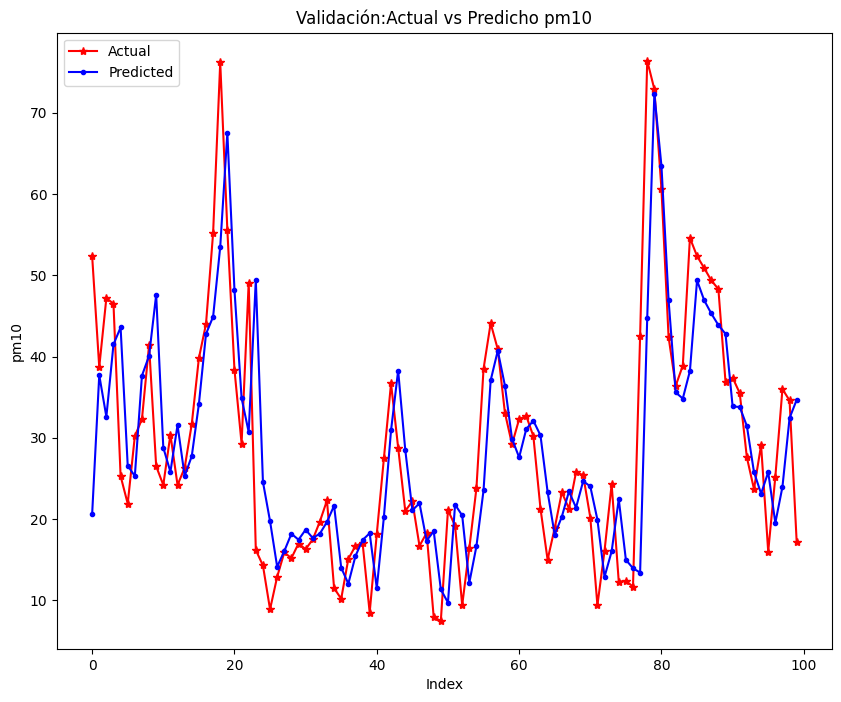

In [23]:
plt.figure(figsize=(10, 8))
plt.plot(range(100), df_val['pm10_arima'].loc[24:123], linestyle='-', marker='*', color='r')
plt.plot(range(100), pred_pm10[:100], linestyle='-', marker='.', color='b')
plt.legend(['Actual','Predicted'], loc=2)
plt.title('Validación:Actual vs Predicho pm10')
plt.ylabel('pm10')
plt.xlabel('Index');

## Evaluación del modelo

In [46]:
best_model = load_model(os.path.join('keras_models', 'PRSA_data_PM10_LSTM_weights.15-0.0326.keras'), compile=False)
predicccion = best_model.predict(X_test)
pred_pm10 = scaler.inverse_transform(predicccion)
pred_pm10 = np.squeeze(pred_pm10)
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(df_test['pm10_arima'].loc[24:], pred_pm10)
mse = mean_squared_error(df_test['pm10_arima'].iloc[24:], pred_pm10)
rmse = np.sqrt(mse)
r2 = r2_score(df_test['pm10_arima'].loc[24:], pred_pm10)

metrics = {
    'Metric': ['MAE', 'MSE', 'RMSE', 'R²'],
    'Value': [round(mae, 4), round(mse, 4), round(rmse, 4), round(r2, 4)]
}
metrics_df = pd.DataFrame(metrics)

# Imprimir el DataFrame
print(metrics_df)


115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
  Metric     Value
0    MAE    8.4940
1    MSE  187.9834
2   RMSE   13.7107
3     R²    0.6870


El R² de aproximadamente 0.6870 muestra que el modelo explica alrededor del 68.70% de la variabilidad en los datos desconocidos.

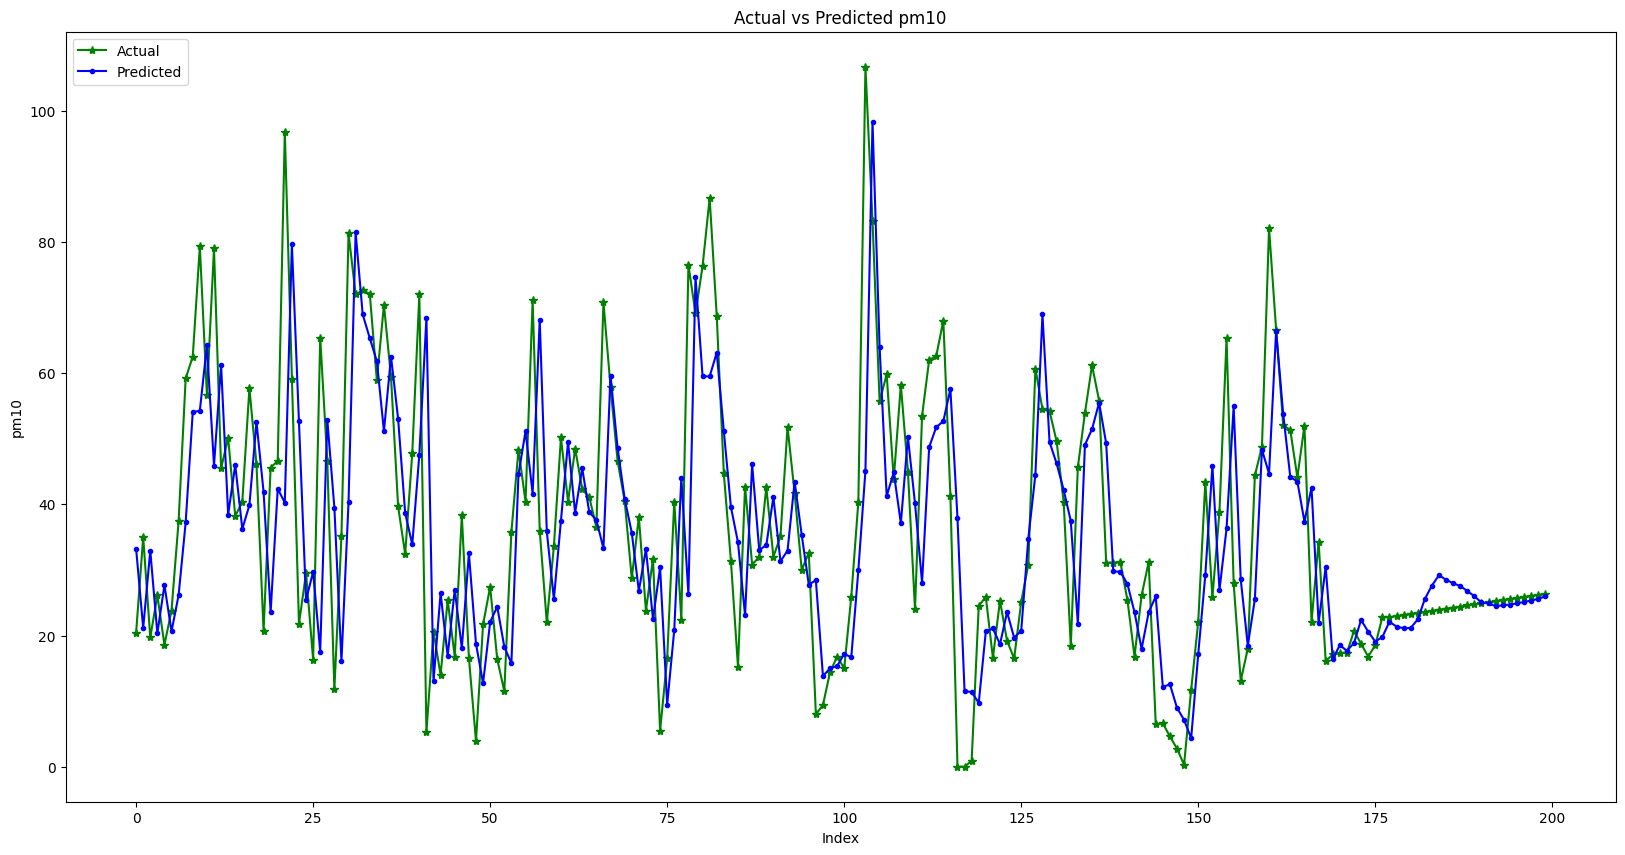

In [47]:
plt.figure(figsize=(20, 10))
plt.plot(range(200), df_test['pm10_arima'].loc[24:223], linestyle='-', marker='*', color='g')
plt.plot(range(200), pred_pm10[:200], linestyle='-', marker='.', color='b')
plt.legend(['Actual','Predicted'], loc=2)
plt.title('Actual vs Predicted pm10')
plt.ylabel('pm10')
plt.xlabel('Index');

### Errores de predicción

La función de autocorrelación ACF nos muestra que los errores de predicción no son independientes

In [48]:
pred_error = np.array(df_test['pm10_arima'].loc[24:223] - np.array(pred_pm10[:200]))

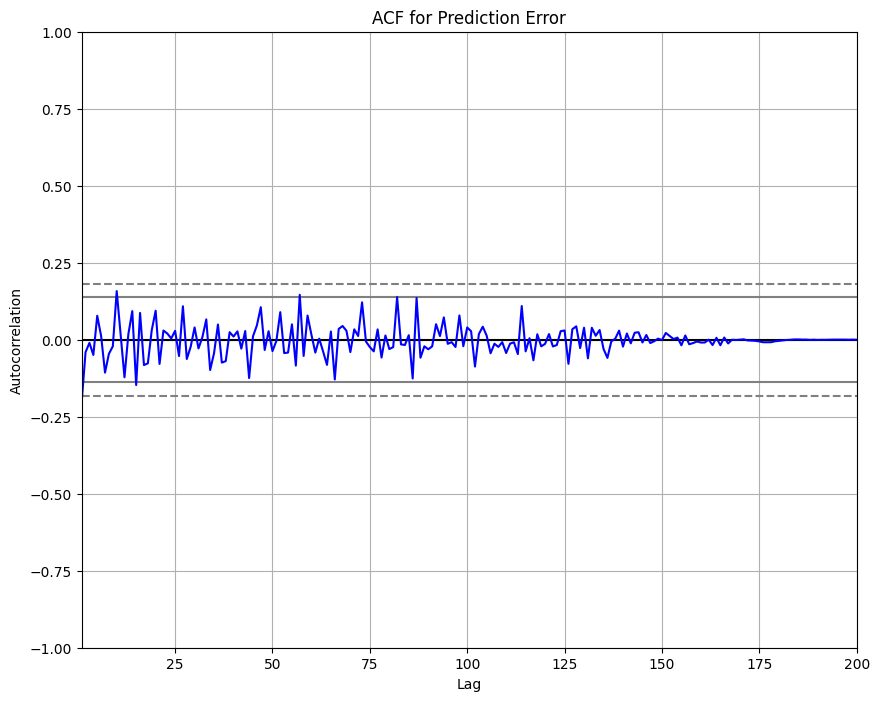

In [49]:
from pandas.plotting import autocorrelation_plot
fig = plt.figure(figsize=(10, 8))
autocorrelation_plot(pred_error, color='b')
plt.title('ACF for Prediction Error');

In [45]:
ljungbo_result1=acorr_ljungbox(pred_error,lags=[24], return_df=True)
print("Ljungbox de los errores en conjunto de test:")
print(ljungbo_result1)

Ljungbox de los errores en conjunto de test:
      lb_stat  lb_pvalue
24  37.061567   0.043145


Dado que el p-valor es menor al nivel de significancia, podemos rechazar la hipótesis nula. Esto sugiere que hay evidencia de autocorrelación en los errores de predicción hasta el rezago 24

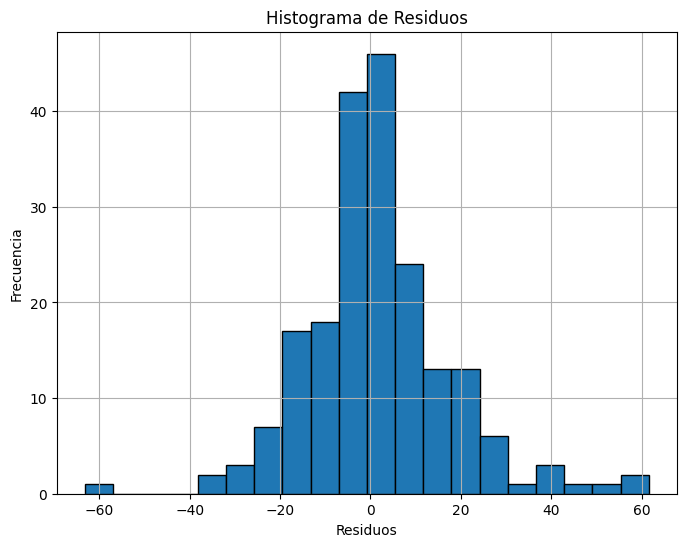

In [51]:
plt.figure(figsize=(8, 6))
plt.hist(pred_error, bins=20, edgecolor='k')
plt.xlabel('Residuos')
plt.ylabel('Frecuencia')
plt.title('Histograma de Residuos')
plt.grid(True)
plt.show()


In [52]:
print(f"Media de los residuos: {pred_error.mean()}")
print(f"Desviación estándar de los residuos: {pred_error.std()}")


Media de los residuos: 1.4835066013191254
Desviación estándar de los residuos: 15.893315269884587


## Conclusiones

 Se identificó que los errores de predicción presentan autocorrelación en rezagos de 24 horas, como lo indican los resultados del estadístico Ljung-Box con un valor p de 0.043145. Esto sugiere que el modelo podría mejorarse para capturar mejor las estructuras temporales diarias o estacionales presentes en los datos

Es recomendable ajustar el modelo LSTM.. Esto podría lograrse mediante la optimización de hiperparámetros como el número de unidades en las capas LSTM, la tasa de aprendizaje del optimizador, o la implementación de técnicas de regularización.